TECX: Period '1mo' is invalid, must be one of ['1d', '5d', 'ytd', 'max']


No data found for TECX, symbol may be delisted


$CHYPF: possibly delisted; No timezone found


No data found for CHYPF, symbol may be delisted


$CICN: possibly delisted; No timezone found


No data found for CICN, symbol may be delisted


$BRRGF: possibly delisted; No timezone found


No data found for BRRGF, symbol may be delisted


$GASMF: possibly delisted; No timezone found


No data found for GASMF, symbol may be delisted


$SNCE: possibly delisted; No timezone found


No data found for SNCE, symbol may be delisted


$GTH: possibly delisted; No timezone found


No data found for GTH, symbol may be delisted


$AMAM: possibly delisted; No timezone found


No data found for AMAM, symbol may be delisted


AXLA: Period '1mo' is invalid, must be one of ['1d', '5d']


No data found for AXLA, symbol may be delisted


$PHXM: possibly delisted; No timezone found


No data found for PHXM, symbol may be delisted


$HARP: possibly delisted; No timezone found


No data found for HARP, symbol may be delisted


$EXPR: possibly delisted; No timezone found


No data found for EXPR, symbol may be delisted


$SUNLQ: possibly delisted; No timezone found


No data found for SUNLQ, symbol may be delisted


$OTMO: possibly delisted; No timezone found


No data found for OTMO, symbol may be delisted


$SNMP: possibly delisted; No timezone found


No data found for SNMP, symbol may be delisted


KeyboardInterrupt: 

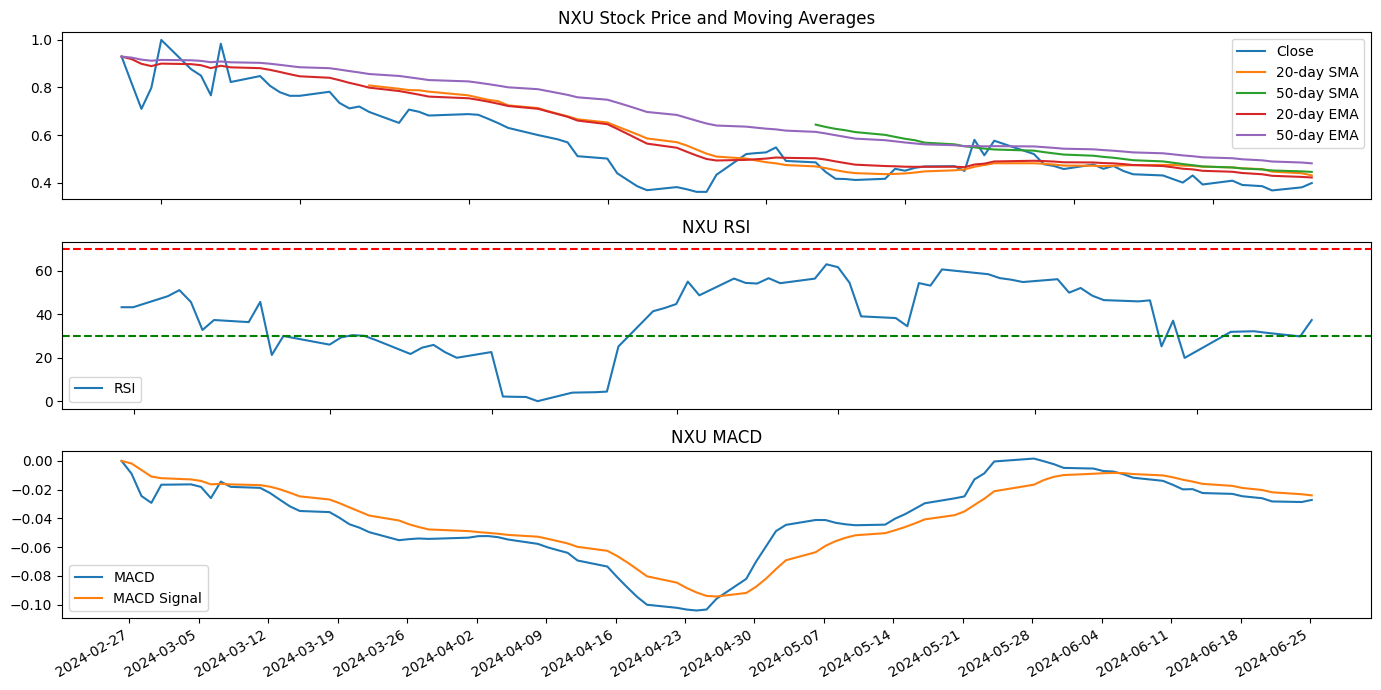

In [2]:
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Read Stock Symbols from the provided CSV file
data_file = 'Combined_Split_Data.csv'
stocks_df = pd.read_csv(data_file)
stock_symbols = stocks_df['Symbol'].tolist()


# Fetch Latest Stock Data
def fetch_stock_data(symbol):
    stock = yf.Ticker(symbol)
    try:
        end_date = datetime.today()
        start_date = end_date - timedelta(days=120)  # Fetch data for the last 4 months
        hist = stock.history(start=start_date, end=end_date)
        if hist.empty:
            print(f"No data found for {symbol}, symbol may be delisted")
            return None

        # Calculate additional indicators
        hist['SMA_20'] = hist['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
        hist['SMA_50'] = hist['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
        hist['EMA_20'] = hist['Close'].ewm(span=20, adjust=False).mean()  # 20-day Exponential Moving Average
        hist['EMA_50'] = hist['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
        hist['RSI'] = calculate_rsi(hist['Close'])  # Relative Strength Index
        hist['ATR'] = calculate_atr(hist)  # Average True Range
        hist['MACD'], hist['MACD_Signal'] = calculate_macd(hist['Close'])  # MACD and MACD Signal
        hist['BB_Upper'], hist['BB_Lower'] = calculate_bollinger_bands(hist['Close'])  # Bollinger Bands
        hist['Stochastic'] = calculate_stochastic(hist)  # Stochastic Oscillator
        hist['ADX'] = calculate_adx(hist)  # Average Directional Index
        hist['CCI'] = calculate_cci(hist)  # Commodity Channel Index

        return hist
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None


def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def calculate_atr(hist, period=14):
    high_low = hist['High'] - hist['Low']
    high_close = np.abs(hist['High'] - hist['Close'].shift())
    low_close = np.abs(hist['Low'] - hist['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr


def calculate_macd(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, macd_signal


def calculate_bollinger_bands(series, window=20):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band


def calculate_stochastic(hist, period=14):
    low_min = hist['Low'].rolling(window=period).min()
    high_max = hist['High'].rolling(window=period).max()
    stochastic = 100 * (hist['Close'] - low_min) / (high_max - low_min)
    return stochastic


def calculate_adx(hist, period=14):
    plus_dm = hist['High'].diff()
    minus_dm = hist['Low'].diff().abs()
    tr = hist[['High', 'Low', 'Close']].diff().abs().max(axis=1)
    plus_di = 100 * (plus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    minus_di = 100 * (minus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    dx = (plus_di - minus_di).abs() / (plus_di + minus_di) * 100
    adx = dx.rolling(window=period).mean()
    return adx


def calculate_cci(hist, period=20):
    tp = (hist['High'] + hist['Low'] + hist['Close']) / 3
    cci = (tp - tp.rolling(window=period).mean()) / (0.015 * tp.rolling(window=period).std())
    return cci


# Save the Fetched Data
output_folder = 'Web_Parse_Data/Stock_Data4'
os.makedirs(output_folder, exist_ok=True)

for symbol in stock_symbols:
    stock_data = fetch_stock_data(symbol)
    if stock_data is not None:
        stock_data.to_csv(f'{output_folder}/{symbol}_data.csv')

# Visualize the Data
for symbol in stock_symbols:
    file_path = f'{output_folder}/{symbol}_data.csv'
    if os.path.exists(file_path):
        stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

        plt.figure(figsize=(14, 7))

        plt.subplot(3, 1, 1)
        plt.plot(stock_data['Close'], label='Close')
        plt.plot(stock_data['SMA_20'], label='20-day SMA')
        plt.plot(stock_data['SMA_50'], label='50-day SMA')
        plt.plot(stock_data['EMA_20'], label='20-day EMA')
        plt.plot(stock_data['EMA_50'], label='50-day EMA')
        plt.title(f'{symbol} Stock Price and Moving Averages')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(stock_data['RSI'], label='RSI')
        plt.axhline(70, color='r', linestyle='--')
        plt.axhline(30, color='g', linestyle='--')
        plt.title(f'{symbol} RSI')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(stock_data['MACD'], label='MACD')
        plt.plot(stock_data['MACD_Signal'], label='MACD Signal')
        plt.title(f'{symbol} MACD')
        plt.legend()

        # Format x-axis to show weekly data
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.savefig(f'{output_folder}/{symbol}_visualization.png')
        plt.close()


In [1]:
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Read Stock Symbols from the provided CSV file
data_file = 'Combined_Split_Data.csv'
stocks_df = pd.read_csv(data_file)
stock_symbols = stocks_df['Symbol'].tolist()


# Fetch Latest Stock Data
def fetch_stock_data(symbol):
    stock = yf.Ticker(symbol)
    try:
        end_date = datetime.today()
        start_date = end_date - timedelta(days=120)  # Fetch data for the last 4 months
        hist = stock.history(start=start_date, end=end_date)
        if hist.empty:
            print(f"No data found for {symbol}, symbol may be delisted")
            return None

        # Calculate additional indicators
        hist['SMA_20'] = hist['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
        hist['SMA_50'] = hist['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
        hist['EMA_20'] = hist['Close'].ewm(span=20, adjust=False).mean()  # 20-day Exponential Moving Average
        hist['EMA_50'] = hist['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
        hist['RSI'] = calculate_rsi(hist['Close'])  # Relative Strength Index
        hist['ATR'] = calculate_atr(hist)  # Average True Range
        hist['MACD'], hist['MACD_Signal'] = calculate_macd(hist['Close'])  # MACD and MACD Signal
        hist['BB_Upper'], hist['BB_Lower'] = calculate_bollinger_bands(hist['Close'])  # Bollinger Bands
        hist['Stochastic'] = calculate_stochastic(hist)  # Stochastic Oscillator
        hist['ADX'] = calculate_adx(hist)  # Average Directional Index
        hist['CCI'] = calculate_cci(hist)  # Commodity Channel Index

        return hist
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None


def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def calculate_atr(hist, period=14):
    high_low = hist['High'] - hist['Low']
    high_close = np.abs(hist['High'] - hist['Close'].shift())
    low_close = np.abs(hist['Low'] - hist['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr


def calculate_macd(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, macd_signal


def calculate_bollinger_bands(series, window=20):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band


def calculate_stochastic(hist, period=14):
    low_min = hist['Low'].rolling(window=period).min()
    high_max = hist['High'].rolling(window=period).max()
    stochastic = 100 * (hist['Close'] - low_min) / (high_max - low_min)
    return stochastic


def calculate_adx(hist, period=14):
    plus_dm = hist['High'].diff()
    minus_dm = hist['Low'].diff().abs()
    tr = hist[['High', 'Low', 'Close']].diff().abs().max(axis=1)
    plus_di = 100 * (plus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    minus_di = 100 * (minus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    dx = (plus_di - minus_di).abs() / (plus_di + minus_di) * 100
    adx = dx.rolling(window=period).mean()
    return adx


def calculate_cci(hist, period=20):
    tp = (hist['High'] + hist['Low'] + hist['Close']) / 3
    cci = (tp - tp.rolling(window=period).mean()) / (0.015 * tp.rolling(window=period).std())
    return cci


# Save the Fetched Data
output_folder = 'Web_Parse_Data/Stock_Data4'
os.makedirs(output_folder, exist_ok=True)

for symbol in stock_symbols:
    stock_data = fetch_stock_data(symbol)
    if stock_data is not None:
        stock_data.to_csv(f'{output_folder}/{symbol}_data.csv')

# Visualize the Data
for symbol in stock_symbols:
    file_path = f'{output_folder}/{symbol}_data.csv'
    if os.path.exists(file_path):
        stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

        plt.figure(figsize=(14, 7))

        plt.subplot(3, 1, 1)
        plt.plot(stock_data['Close'], label='Close')
        plt.plot(stock_data['SMA_20'], label='20-day SMA')
        plt.plot(stock_data['SMA_50'], label='50-day SMA')
        plt.plot(stock_data['EMA_20'], label='20-day EMA')
        plt.plot(stock_data['EMA_50'], label='50-day EMA')
        plt.title(f'{symbol} Stock Price and Moving Averages')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(stock_data['RSI'], label='RSI')
        plt.axhline(70, color='r', linestyle='--')
        plt.axhline(30, color='g', linestyle='--')
        plt.title(f'{symbol} RSI')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(stock_data['MACD'], label='MACD')
        plt.plot(stock_data['MACD_Signal'], label='MACD Signal')
        plt.title(f'{symbol} MACD')
        plt.legend()

        # Format x-axis to show weekly data
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.savefig(f'{output_folder}/{symbol}_visualization.png')
        plt.close()


/Users/ardadinc/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [7]:
import pandas as pd
import yfinance as yf
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.utils import ImageReader

# Read Stock Symbols from the provided CSV file
data_file = 'Combined_Split_Data.csv'
stocks_df = pd.read_csv(data_file)
stock_symbols = stocks_df['Symbol'].tolist()

# Fetch Latest Stock Data
def fetch_stock_data(symbol):
    stock = yf.Ticker(symbol)
    try:
        end_date = datetime.today()
        start_date = end_date - timedelta(days=120)  # Fetch data for the last 4 months
        hist = stock.history(start=start_date, end=end_date)
        if hist.empty:
            print(f"No data found for {symbol}, symbol may be delisted")
            return None

        # Calculate additional indicators
        hist['SMA_20'] = hist['Close'].rolling(window=20).mean()  # 20-day Simple Moving Average
        hist['SMA_50'] = hist['Close'].rolling(window=50).mean()  # 50-day Simple Moving Average
        hist['EMA_20'] = hist['Close'].ewm(span=20, adjust=False).mean()  # 20-day Exponential Moving Average
        hist['EMA_50'] = hist['Close'].ewm(span=50, adjust=False).mean()  # 50-day Exponential Moving Average
        hist['RSI'] = calculate_rsi(hist['Close'])  # Relative Strength Index
        hist['ATR'] = calculate_atr(hist)  # Average True Range
        hist['MACD'], hist['MACD_Signal'] = calculate_macd(hist['Close'])  # MACD and MACD Signal
        hist['BB_Upper'], hist['BB_Lower'] = calculate_bollinger_bands(hist['Close'])  # Bollinger Bands
        hist['Stochastic'] = calculate_stochastic(hist)  # Stochastic Oscillator
        hist['ADX'] = calculate_adx(hist)  # Average Directional Index
        hist['CCI'] = calculate_cci(hist)  # Commodity Channel Index

        return hist
    except Exception as e:
        print(f"Error fetching data for {symbol}: {e}")
        return None

def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(hist, period=14):
    high_low = hist['High'] - hist['Low']
    high_close = np.abs(hist['High'] - hist['Close'].shift())
    low_close = np.abs(hist['Low'] - hist['Close'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    atr = true_range.rolling(window=period).mean()
    return atr

def calculate_macd(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    macd_signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, macd_signal

def calculate_bollinger_bands(series, window=20):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * 2)
    lower_band = sma - (std * 2)
    return upper_band, lower_band

def calculate_stochastic(hist, period=14):
    low_min = hist['Low'].rolling(window=period).min()
    high_max = hist['High'].rolling(window=period).max()
    stochastic = 100 * (hist['Close'] - low_min) / (high_max - low_min)
    return stochastic

def calculate_adx(hist, period=14):
    plus_dm = hist['High'].diff()
    minus_dm = hist['Low'].diff().abs()
    tr = hist[['High', 'Low', 'Close']].diff().abs().max(axis=1)
    plus_di = 100 * (plus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    minus_di = 100 * (minus_dm.rolling(window=period).sum() / tr.rolling(window=period).sum())
    dx = (plus_di - minus_di).abs() / (plus_di + minus_di) * 100
    adx = dx.rolling(window=period).mean()
    return adx

def calculate_cci(hist, period=20):
    tp = (hist['High'] + hist['Low'] + hist['Close']) / 3
    cci = (tp - tp.rolling(window=period).mean()) / (0.015 * tp.rolling(window=period).std())
    return cci

# Save the Fetched Data
output_folder = 'Web_Parse_Data/Stock_Data4'
os.makedirs(output_folder, exist_ok=True)

for symbol in stock_symbols:
    stock_data = fetch_stock_data(symbol)
    if stock_data is not None:
        stock_data.to_csv(f'{output_folder}/{symbol}_data.csv')

# Visualize the Data
for symbol in stock_symbols:
    file_path = f'{output_folder}/{symbol}_data.csv'
    if os.path.exists(file_path):
        stock_data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

        plt.figure(figsize=(12, 16))  # Adjust figure size to ensure it looks good in the PDF

        plt.subplot(3, 1, 1)
        plt.plot(stock_data['Close'], label='Close')
        plt.plot(stock_data['SMA_20'], label='20-day SMA')
        plt.plot(stock_data['SMA_50'], label='50-day SMA')
        plt.plot(stock_data['EMA_20'], label='20-day EMA')
        plt.plot(stock_data['EMA_50'], label='50-day EMA')
        plt.title(f'{symbol} Stock Price and Moving Averages')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(stock_data['RSI'], label='RSI')
        plt.axhline(70, color='r', linestyle='--')
        plt.axhline(30, color='g', linestyle='--')
        plt.title(f'{symbol} RSI')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(stock_data['MACD'], label='MACD')
        plt.plot(stock_data['MACD_Signal'], label='MACD Signal')
        plt.title(f'{symbol} MACD')
        plt.legend()

        # Format x-axis to show weekly data
        plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.savefig(f'{output_folder}/{symbol}_visualization.png', bbox_inches='tight')  # Save with tight bounding box
        plt.close()

# Create a PDF with the Visualizations
pdf_path = 'Stock_Visualizations.pdf'
c = canvas.Canvas(pdf_path, pagesize=letter)

for symbol in stock_symbols:
    img_path = f'{output_folder}/{symbol}_visualization.png'
    if os.path.exists(img_path):
        c.drawImage(ImageReader(img_path), 0, 0, width=letter[0], height=letter[1])  # Use full page size for images
        c.showPage()

c.save()

print(f"PDF saved as {pdf_path}")


PDF saved as Stock_Visualizations.pdf
